#### Utility Functions

In [1]:
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import os
from utilities import *

In [129]:
# TESTING:

with Dataset(source_file, 'r') as src:
    for k in src.ncattrs():
        print(f"{k}: {src.getncattr(k)}")
    
    for name, dimension in src.dimensions.items():
        if not name == 'expver':
            print(f"{name}: {len(dimension) if not dimension.isunlimited() else 'unlimited'}")
    
    for name, variable in src.variables.items():
        if name in ['time', 'latitude', 'longitude', 'u', 'v']:
            print(f"{name}: {variable.datatype}, {variable.dimensions}")
            for k in variable.ncattrs():
                print(f"  {k}: {variable.getncattr(k)}")
            
    # for name, variable in variables.items():
    #     print(f"{name}: {variable}")

Conventions: CF-1.6
history: 2024-07-12 00:20:23 GMT by grib_to_netcdf-2.28.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data8/adaptor.mars.internal-1720743622.4797337-1546-7-491f5957-9e6d-4a44-b45a-e3e27d89a58e.nc /cache/tmp/491f5957-9e6d-4a44-b45a-e3e27d89a58e-adaptor.mars.internal-1720743617.0208066-1546-3-tmp.grib
longitude: 1440
latitude: 721
time: 18
longitude: float32, ('longitude',)
  units: degrees_east
  long_name: longitude
latitude: float32, ('latitude',)
  units: degrees_north
  long_name: latitude
time: int32, ('time',)
  units: hours since 1900-01-01 00:00:00.0
  long_name: time
  calendar: gregorian
u: int16, ('time', 'expver', 'latitude', 'longitude')
  scale_factor: 0.0006413783645530925
  add_offset: -0.1487353009986828
  _FillValue: -32767
  missing_value: -32767
  units: m s**-1
  long_name: U component of wind
  standard_name: eastward_wind
v: int16, ('time', 'expver', 'latitude', 'longitude')
  scale_factor: 0.0006212465854009293
  add_offset: 

#### Do only once:

In [ ]:
# Convert your NetCDF3 file to NetCDF4
convert_to_netcdf4('./data/era5_wind_sress.nc', './data/era5_wind_sress_converted.nc')

#### Upload data

In [2]:
# Calculate wind speed
source_file = './data/era5_wind_sress_converted.nc'

d = Dataset(source_file,'r')
print(d.variables.keys())

variables = {'wind_speed': {'data': calculate_wind_speed(d),
                            'dimensions': ('time', 'latitude', 'longitude'),
                            'datatype': 'float64',
                            'attributes': {'long_name': 'Wind speed',
                                           'units': 'm/s',
                                           'standard_name': 'wind_speed'}}}

dict_keys(['longitude', 'latitude', 'expver', 'time', 'u', 'v'])
No missing values in u variable found.
No missing values in v variable found.


In [135]:
wind_start_year = nc.num2date(d.variables['time'][:], units=d.variables['time'].units)[0].year
wind_end_year = nc.num2date(d.variables['time'][:], units=d.variables['time'].units)[-1].year

In [138]:
new_file = f'./data/wind_speed_{wind_start_year}_{wind_end_year}.nc'
save_to_netcdf4(source_file, new_file, variables)

Saved to ./data/wind_speed_2023_2024.nc


### Changing format of other files

In [2]:
# Convert your NetCDF3 file to NetCDF4
folder_path = './data/'
ERA5_files = ['PRECIP_NCEP_GPCC_Reanalysis_1948-2019.nc'] #['ERA5_SST_1940-2024.nc', 'ERA5_mean_precipitation_1940-2024.nc', 'ERA5_mean_SLP_1940-2024.nc']
variables = ['precip'] # ['sst', 'mtpr', 'msl']

for file, var in zip(ERA5_files, variables):
    final_file = file.replace('.nc', '_converted.nc')
    convert_to_netcdf4(folder_path, file, final_file, var)

Data shape:  (960, 320, 320)
Converted PRECIP_NCEP_GPCC_Reanalysis_1948-2019.nc to PRECIP_NCEP_GPCC_Reanalysis_1948-2019_converted.nc


In [3]:
# Confirm everything is correct
for file, var in zip(ERA5_files, variables):
    data = Dataset(folder_path + file.replace('.nc', '_converted.nc'), 'r')
    print(data)
    print(data.variables[var].shape)
    data.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: CF 1.0
    Original_Source: http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm
 is the webpage and the data is at ftp://ftp.dwd.de/pub/data/gpcc/download.html
    Reference: Users of the data sets are kindly requested to give feed back and to refer to GPCC publications on this webpage: http://www.dwd.de/bvbw/appmanager/bvbw/dwdwwwDesktop/?_nfpb=true&_pageLabel=_dwdwww_klima_umwelt_datenzentren_wzn&T12404518261141645246564gsbDocumentPath=Content%2FOeffentlichkeit%2FKU%2FKU4%2FKU42%2Fteaser__product__access.html&_state=maximized&_windowLabel=T12404518261141645246564&lastPageLabel=_dwdwww_klima_umwelt_datenzentren_wzn
    original_source: ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_download.html
    dataset_title: Global Precipitation Climatology Centre (GPCC)
    title: GPCC Full Data Reanalysis Versio

In [4]:
# detrend the datasets
!cdo detrend ./data/PRECIP_NCEP_GPCC_Reanalysis_1948-2019_converted.nc ./data/PRECIP_NCEP_GPCC_Reanalysis_1948-2019_converted_detrend.nc

cdo    detrend:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 910cdo    detrend: Processed 98304000 values from 1 variable over 960 timesteps [0.90s 411MB]


In [5]:
# Confirm everything is correct in the detrended files 
for file, var in zip(ERA5_files, variables):
    data = Dataset(folder_path + file.replace('.nc', '_converted_detrend.nc'), 'r')
    print(data)
    print(data.variables[var].shape)
    data.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 2.4.2 (https://mpimet.mpg.de/cdi)
    Conventions: CF 1.0
    Original_Source: http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm
 is the webpage and the data is at ftp://ftp.dwd.de/pub/data/gpcc/download.html
    Reference: Users of the data sets are kindly requested to give feed back and to refer to GPCC publications on this webpage: http://www.dwd.de/bvbw/appmanager/bvbw/dwdwwwDesktop/?_nfpb=true&_pageLabel=_dwdwww_klima_umwelt_datenzentren_wzn&T12404518261141645246564gsbDocumentPath=Content%2FOeffentlichkeit%2FKU%2FKU4%2FKU42%2Fteaser__product__access.html&_state=maximized&_windowLabel=T12404518261141645246564&lastPageLabel=_dwdwww_klima_umwelt_datenzentren_wzn
    original_source: ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_download.html
    dataset_title: Global Precipitation Climatology Centre (GPCC)
    title: GPCC Full Data Reanalysis Version

In [97]:
from utils_pca_fun import *
import pandas as pd
import numpy as np
from netCDF4 import Dataset
from geo_field_jakob import GeoField

d = {}

ERA5_files = [
    'ERA5_SST_1940-2024_converted_detrend.nc',
    # 'PRATE_NCEP_NCAR_Reanalysis_1948-2024.nc'
    ]

variables = [
    'sst',
    # 'prate'
    ]

lats = [-66, 48] # SST
# lats = [-20, 1] # PRATE

lons = [150, 360] # SST
# lons = [310, 325] # PRATE

d['data_parameters'] = {
    'folder_name' : './data/',
    'load_filename' :  ERA5_files[0], 
    'varname' : variables[0],
                
    'use_cdftime' : True,
    'from_date' : datetime(1948, 1, 1),
    'to_date' : datetime(2024, 1, 1), 
    'anomalize': 'means_variance',
    'anomalize_base' :  (1948, 2019),
    'slice_lat' : lats, # [-20, 1], #
    'slice_lon' : lons, # [310, 325], # 
    'level' : None,   
    'verbosity' : 2,
    }

geo_object = load_data(**d['data_parameters'])
data = geo_object.data()
start_end_date = [geo_object.start_date, geo_object.end_date]

INFO:root:funciona


Loading data:
	Original date range 1940-01-01 00:00:00 - 2024-06-01 00:00:00 
Original data shape (1014, 721, 1440)
	Slicing lon = [150, 360], lat = [-66, 48]
	anomalize means_variance with base period (1948, 2019)
Stard and end dates:  1940-01-01 00:00:00 2024-06-01 00:00:00
	Slicing from = 1948-01-01 00:00:00 to 2024-01-01 00:00:00
Stard and end dates after slicing:  1948-01-01 00:00:00 2023-12-01 00:00:00


2016 DJF season index: 11


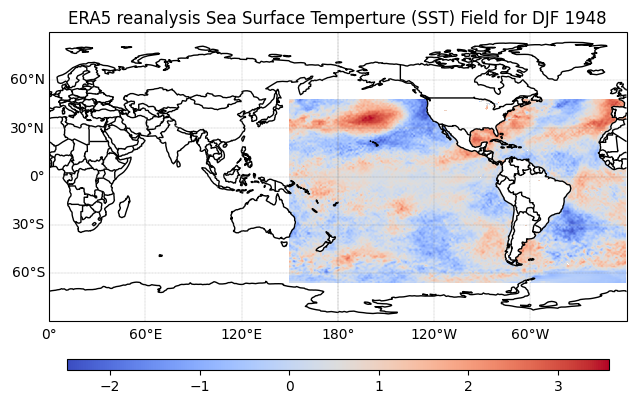

In [98]:
# For SST
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

daterange = pd.date_range(start_end_date[0], start_end_date[1], freq='M')
idx = daterange.get_loc('1948-12-31')
print('2016 DJF season index:', idx)

lats, lons = geo_object.lats, geo_object.lons
prep = data[idx:(idx+3), :, :]
# Reshape the predicted loadings to a (n_lat, n_lon) grid
predicted_loadings_grid = np.mean(prep, axis=0)

# Plotting the map
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
# ax.set_extent([lons.min() - 50, lons.max() + 10, lats.min() - 50, lats.max() + 30], crs=ccrs.PlateCarree())
ax.set_global()

# Add gridlines and label them
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth=0.2, linestyle='--', color='gray')
gl.right_labels = False
gl.top_labels = False

# Plot the data on the map
mesh = ax.pcolormesh(lons, lats, predicted_loadings_grid, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
# Add a colorbar
plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.1, aspect=50, shrink=0.70)
plt.title('ERA5 reanalysis Sea Surface Temperture (SST) Field for DJF 1948')
plt.show()

2016 DJF season index: 11


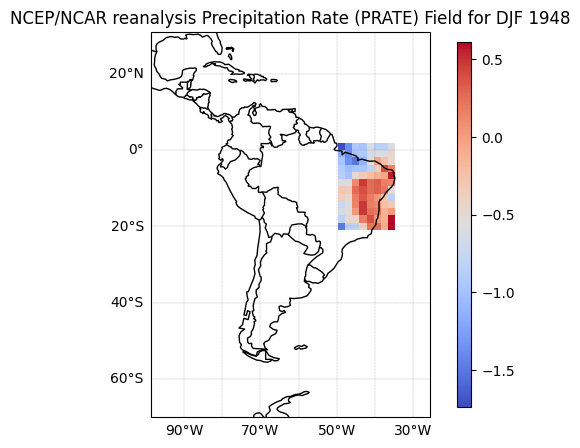

In [95]:
# For PRATE

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

daterange = pd.date_range(start_end_date[0], start_end_date[1], freq='M')
idx = daterange.get_loc('1948-12-31')
print('2016 DJF season index:', idx)

lats, lons = geo_object.lats, geo_object.lons
prep = data[(idx):(idx+3), :, :]
# Reshape the predicted loadings to a (n_lat, n_lon) grid
predicted_loadings_grid = np.mean(prep, axis=0)

# Plotting the map
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_extent([lons.min() - 50, lons.max() + 10, lats.min() - 50, lats.max() + 30], crs=ccrs.PlateCarree())
# ax.set_global()

# Add gridlines and label them
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth=0.2, linestyle='--', color='gray')
gl.right_labels = False
gl.top_labels = False

# Plot the data on the map
mesh = ax.pcolormesh(lons, lats, predicted_loadings_grid, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
# Add a colorbar
plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.035, aspect=25, shrink=0.95)
# plt.title('ERA5 reanalysis Sea Surface Temperture (SST) Field for DJF 1948')
plt.title('NCEP/NCAR reanalysis Precipitation Rate (PRATE) Field for DJF 1948')
plt.show()